In [1]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Activation,
    Dense,
    Dropout,
    Flatten,
    InputLayer,
)

from keras.models import (
    Sequential, 
    Model
)

from keras.applications import vgg16, ResNet50

In [2]:
DATA_PATH = '/content/drive/MyDrive/Kim/pose.mat'
INPUT_SHAPE = (48, 40, 3)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
poses = loadmat(DATA_PATH)['pose']
poses = poses.transpose([3, 2, 0 ,1]).reshape(68, 13, 48, 40)

TRAIN_POSE_COUNT = 10
TEST_POSE_COUNT = 13 - TRAIN_POSE_COUNT
SUBJECT_COUNTS = 68

# Normalize the data as well
# using the first 10 poses of each subject for train
X_train = poses[:, :TRAIN_POSE_COUNT, :, :]/255.

# using the last 3 poses of each subject for test
X_test = poses[:, TRAIN_POSE_COUNT:, :, :]/255.

In [5]:
X_train.shape

(68, 10, 48, 40)

In [6]:
def combine_images(arr):
    """
    Param: (np.arr) numpy 4D array
    Return: (np.arr) numpy 2D array with images combined 
    """
    
    return arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2], arr.shape[3], 1)

X_train = combine_images(X_train)
X_test = combine_images(X_test)

In [7]:
def duplicate_channels(arr):
    """
    Param: (np.arr) numpy 4D array with 1 channel
    Returns: 
        (np.arr) numpy 4D array with 2 more duplicated channels 
        concatenated with the original array
    """

    arr = np.squeeze(np.stack((arr,) * 3, -1))
    return arr

X_train = duplicate_channels(X_train)
X_test = duplicate_channels(X_test)
X_train.shape, X_test.shape

((680, 48, 40, 3), (204, 48, 40, 3))

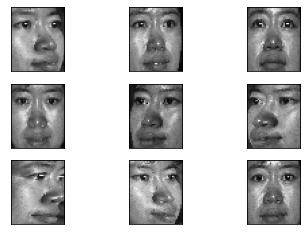

In [8]:
fig, ax = plt.subplots(3,3)

# first 9 images for one subject, each with a diff pose
for i, axis in enumerate(ax.flat):
    axis.imshow(X_train[i].squeeze(), cmap='bone')
    axis.set(xticks=[], yticks=[])

In [9]:
# each subject has 10 images consecutive in the train data 
y_train = np.concatenate([np.ones(TRAIN_POSE_COUNT) * i for i in range(X_train.shape[0] // TRAIN_POSE_COUNT)])
y_train = y_train.reshape(-1, 1)
# each subject has 3 images consecutive in the test data 
y_test = np.concatenate([np.ones(TEST_POSE_COUNT) * i for i in range(X_test.shape[0] // TEST_POSE_COUNT)])
y_test = y_test.reshape(-1, 1)

In [10]:
print(f"Train data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Train data shape: X_train: (680, 48, 40, 3), y_train: (680, 1)
Test data shape: X_test: (204, 48, 40, 3), y_test: (204, 1)


# Architecture

Due to small dataset, the model overfits the data quite easily. To reduce it, I included Dropout and also reduced the deepness of the architecure.

The most difficult hyperparameter to set was the learning rate. I believe `0.0007` to be the most optimized for our use. 

In [14]:
model = None
model = Sequential(
    [
        Conv2D(filters=32,
            kernel_size=(3,3), 
            strides=(1,1),
            padding="same",
            kernel_initializer="glorot_uniform"),

        MaxPooling2D(pool_size=(2,2), 
            strides=(1,1),
            padding="valid",
            ),
     
        Activation(tf.nn.relu),

        Conv2D(filters=64, 
            kernel_size=(5,5),
            strides=2,
            padding="same", 
            kernel_initializer="glorot_uniform"),

        MaxPooling2D(pool_size=(2,2),
            strides=(1,1),
            padding="valid"), 
     
        Activation(tf.nn.relu),

        Flatten(),
        Dropout(0.7),

        Dense(SUBJECT_COUNTS, 
        kernel_initializer="glorot_uniform",
        activation="softmax")   
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.00075)
model.compile(optimizer=optimizer, 
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

In [15]:
history = model.fit(X_train, y_train, 
                epochs=30, 
                validation_data=(X_test, y_test),
                verbose=2
            )

Epoch 1/30
22/22 - 5s - loss: 4.3075 - accuracy: 0.0088 - val_loss: 4.2187 - val_accuracy: 0.0196
Epoch 2/30
22/22 - 5s - loss: 4.2176 - accuracy: 0.0309 - val_loss: 4.2102 - val_accuracy: 0.0833
Epoch 3/30
22/22 - 5s - loss: 4.2031 - accuracy: 0.0382 - val_loss: 4.1603 - val_accuracy: 0.0392
Epoch 4/30
22/22 - 5s - loss: 4.0492 - accuracy: 0.0941 - val_loss: 3.9203 - val_accuracy: 0.1127
Epoch 5/30
22/22 - 4s - loss: 3.4776 - accuracy: 0.1941 - val_loss: 3.0985 - val_accuracy: 0.3186
Epoch 6/30
22/22 - 5s - loss: 2.5442 - accuracy: 0.3618 - val_loss: 2.4602 - val_accuracy: 0.3725
Epoch 7/30
22/22 - 4s - loss: 1.6750 - accuracy: 0.5838 - val_loss: 2.0100 - val_accuracy: 0.4902
Epoch 8/30
22/22 - 5s - loss: 1.0942 - accuracy: 0.6956 - val_loss: 1.8159 - val_accuracy: 0.5539
Epoch 9/30
22/22 - 4s - loss: 0.8250 - accuracy: 0.7721 - val_loss: 1.7041 - val_accuracy: 0.5882
Epoch 10/30
22/22 - 5s - loss: 0.5290 - accuracy: 0.8456 - val_loss: 1.7263 - val_accuracy: 0.5588
Epoch 11/30
22/22 -

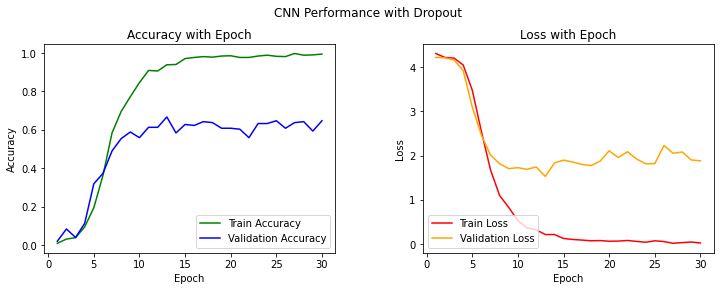

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle("CNN Performance with Dropout")
fig.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, 31))
ax1.plot(epochs, history.history['accuracy'], label="Train Accuracy", color="green")
ax1.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", color="blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy with Epoch")
l1 = ax1.legend(loc="lower right")

epochs = list(range(1, 31))
ax2.plot(epochs, history.history['loss'], label="Train Loss", color="red")
ax2.plot(epochs, history.history['val_loss'], label="Validation Loss", color="orange")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss with Epoch")
l1 = ax2.legend(loc="lower left")

# Transfer Learning

In [19]:
vgg = vgg16.VGG16(include_top=False,
                  weights="imagenet",
                  input_shape=INPUT_SHAPE,
                )

output = vgg.layers[-1].output
output = Flatten()(output)
vgg_model = Model(inputs=vgg.input, outputs=output, name="vgg_feature_extractor")

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False   

vgg_model.summary()     

Model: "vgg_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 40, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 20, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 10, 1

In [20]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=1)

    assert features.shape == (input_imgs.shape[0], model.layers[-1].output.shape[1])
    return features
    
train_features = get_bottleneck_features(vgg_model, X_train)    
val_features = get_bottleneck_features(vgg_model, X_test)

print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)

7/7 [==============================] - 3s 484ms/step
Train features shape: (680, 512)
Validation features shape: (204, 512)


In [21]:
input_shape = vgg_model.output.shape[1]

model = Sequential()

model.add(InputLayer(input_shape=(input_shape,)))

model.add(Dense(512, 
        activation='relu',
        input_dim=input_shape
    ))

model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(SUBJECT_COUNTS, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.00075),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 68)                34884     
Total params: 560,196
Trainable params: 560,196
Non-trainable params: 0
_________________________________________________________________


In [22]:
print(f"Train data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Train data shape: X_train: (680, 48, 40, 3), y_train: (680, 1)
Test data shape: X_test: (204, 48, 40, 3), y_test: (204, 1)


In [23]:
history = model.fit(x=train_features,
                    y=y_train,
                    validation_data=(val_features, y_test),
                    epochs=100,
                    verbose=1)

Epoch 1/100
22/22 [==============================] - 1s 16ms/step - loss: 4.3662 - accuracy: 0.0117 - val_loss: 4.1231 - val_accuracy: 0.0686
Epoch 2/100
22/22 [==============================] - 0s 9ms/step - loss: 4.1258 - accuracy: 0.0544 - val_loss: 4.0004 - val_accuracy: 0.1373
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 3.9359 - accuracy: 0.1065 - val_loss: 3.7752 - val_accuracy: 0.2108
Epoch 4/100
22/22 [==============================] - 0s 9ms/step - loss: 3.6261 - accuracy: 0.1394 - val_loss: 3.4740 - val_accuracy: 0.2353
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 3.2988 - accuracy: 0.1909 - val_loss: 3.1511 - val_accuracy: 0.3186
Epoch 6/100
22/22 [==============================] - 0s 9ms/step - loss: 3.0351 - accuracy: 0.2200 - val_loss: 2.9524 - val_accuracy: 0.3186
Epoch 7/100
22/22 [==============================] - 0s 9ms/step - loss: 2.6116 - accuracy: 0.3258 - val_loss: 2.7352 - val_accuracy: 0.3775
Epoch 8/100
